# Tutorial 2 - AquaHarmonics
The goal of this tutorial is to illustrate a more realistic model of a PTO, including non-linear power conversion chain. 
It uses the [AquaHarmonics](https://aquaharmonics.com/wec_vis/) device in one degree of freedom in regular waves, models the PTO generator using a motor power loss map and adds realistic constraints, including generator maximum torque and min/max line tension.

This tutorial is comprises two parts, where the second section builds upon the first.

1. [Optimal control with a loss map](#1.-Optimal-control-with-a-loss-map)
2. [Control co-design of line pre-tension/ballast with non-linear power conversion](#2.-Control-co-design-of-line-pre-tension/ballast)

![AquaHarmonics device](https://aquaharmonics.com/wec_vis.png)

In [1]:
import os
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import brute
import xarray as xr
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.DEBUG)

import wecopttool as wot

## 1. Optimal control with a loss map

### WEC object
We will go through a number of steps to create a `WEC` object, with which we can solve for the optimal control trajectory.
To compose the `WEC` object, we will need to define the mesh, degrees of freedom, mass and hydrostatic properties, linear hydrodynamic coefficients (from a BEM solution), any additional dynamic forces (e.g. PTO force), and constraints (e.g. minimum line tension).  

#### Geometry
First we create a surface mesh for the WEC hull, and quickly visualize the cross-sectional shape of the hull.
The AquaHarmonics hull mesh is already included with WecOptTool—take a look at the `geometry.py` module if you're interested in seeing how it was created.
Note that the lower cylindrical section of the hull is open to the sea.

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntr

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CHILLER.TTF', name='Chiller', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-regular.otf', name='Adobe Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLB.TTF', name='Bell MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Font

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-bold.otf', name='Adobe Arabic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\KUNSTL

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swcomp.ttf', name='SWComp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjh.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgreks.ttf', name='SWGreks', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCM_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyh.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKI.TTF', name='Rockwell', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuiz.ttf', name='Segoe UI', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ntailu.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrili.ttf', name='Calibri', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspa.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LATINWD.TTF', name='Wide Latin', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILLUBCD.TTF', name='Gill Sans Ultra Bold Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constanb.ttf', name='Constantia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERTIBD.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-BOLD.TTF', name='Dubai', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd-bold.otf', name='Courier Std', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKEB.

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mvboli.ttf', name='MV Boli', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelb.ttf', name='Corbel', style='normal', variant='normal', weight=700, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\OLDENGL.TTF', name='Old English Text MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSDI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_PSTC.TTF', name='Bodoni MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgrekc.ttf', name='SWGrekc', style='normal', variant='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTBI.TTF', name='Calisto MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NirmalaS.ttf', name='Nirmala UI', style='normal', variant='normal', weight=350, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolab.ttf', name='Consolas', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAGE.TTF', name='Rage Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibriz.ttf', name='Calibri', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRLNSDB.TTF', name='Berlin Sans FB Demi', style='normal', variant='normal', weight=700, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CURLZ___.TTF', name='Curlz MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HARLOWSI.TTF', name='Harlow Solid Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariblk.ttf', name='Arial', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 6.888636363636364
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SNAP____.TTF', name='Snap ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VIVALDII.TTF', name='Vivaldi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisb.ttf', name='Segoe UI', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.


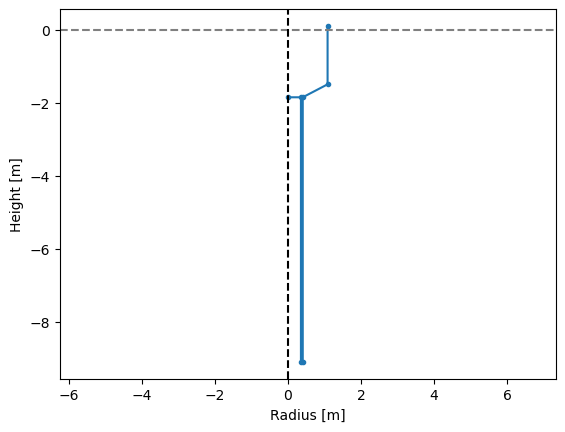

In [2]:
ah_hull = wot.geom.AquaHarmonics()
mesh = ah_hull.mesh(mesh_size_factor=0.25)
_ = ah_hull.plot_cross_section()

Next we create a `FloatingBody` object from the mesh in Capytaine, which we will use to calculate the hydrodynamics.
We can visualize a 3D rendering of the mesh now as well.

INFO:capytaine.io.meshio:Stored 2358 triangle faces as quadrilaterals
INFO:capytaine.io.meshio:Stored 2358 triangle faces as quadrilaterals
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=1364, nb_faces=2358, name=AquaHarmonics)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=1364, nb_faces=2358, name=AquaHarmonics)
DEBUG:capytaine.meshes.quality:* Removing unused vertices in the mesh:
DEBUG:capytaine.meshes.quality:* Removing unused vertices in the mesh:
DEBUG:capytaine.meshes.quality:	--> 183 unused vertices have been removed
DEBUG:capytaine.meshes.quality:	--> 183 unused vertices have been removed
DEBUG:capytaine.meshes.quality:* Removing degenerated faces
DEBUG:capytaine.meshes.quality:* Removing degenerated faces
DEBUG:capytaine.meshes.quality:	--> No degenerated faces
DEBUG:capytaine.meshes.quality:	--> No degenerated faces
DEBUG:capytaine.meshes.quality:* Merging duplicate vertices that lie in an absolute proximity of 1.0E-08...
DEBUG:capytaine.meshes.quality:*

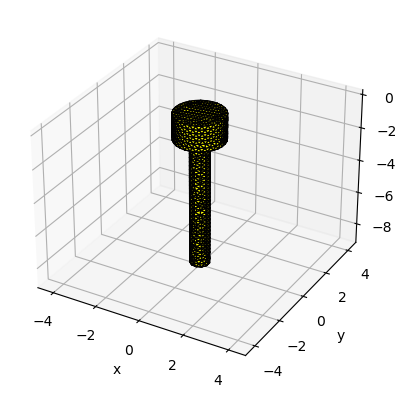

In [3]:
fb = cpy.FloatingBody.from_meshio(mesh, name="AquaHarmonics")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs
fb.show_matplotlib()

#### Hydrostatics and mass
The AquaHarmonics device is positively buoyant (i.e., the buoyancy force is greater than the force due to gravity).
Therefore, we'll set the rigid-body mass manually, but allow the hydrostatic stiffness to be set automatically by run_bem() based on the mesh. We will also calculate the displaced volume and mass from the mesh (before manually defining the mass of the FloatingBody), which we will need later for defining forces and constraints.

In [4]:
g = 9.81
rho = 1025
displaced_mass = wot.hydrostatics.inertia_matrix(fb, rho).values  # [kg]
displacement = displaced_mass/rho # [m^3] 

fb.mass = np.atleast_2d(5e3) # [kg]

INFO:wecopttool.hydrostatics:Using the geometric centroid as the center of gravity (COG).
INFO:wecopttool.hydrostatics:Using the geometric centroid as the center of gravity (COG).
INFO:wecopttool.hydrostatics:Using the center of gravity (COG) as the rotation center for hydrostatics.
INFO:wecopttool.hydrostatics:Using the center of gravity (COG) as the rotation center for hydrostatics.
DEBUG:capytaine.bodies.bodies:Copy AquaHarmonics under the name AquaHarmonics_immersed.
DEBUG:capytaine.bodies.bodies:Copy AquaHarmonics under the name AquaHarmonics_immersed.
INFO:capytaine.bodies.bodies:Clipping AquaHarmonics_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping AquaHarmonics_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=102, nb_faces=173, name=mesh_0)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=102, nb_faces=173, name=mesh_0)
DEBUG:capytaine.me

#### Hydrodynamics

Next we will run the boundary element model (BEM) [Capytaine](https://github.com/capytaine/capytaine) to obtain the hydrodynamic coefficients for the hull.
Before running the BEM solver, we must specify a set of frequencies at which to perform the calculations.
For `WecOptTool`, these must be a regularly spaced frequency array.

In [5]:
f1 = 0.06 # [Hz]
nfreq = 20
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

bem_data = wot.run_bem(fb, freq, rho=rho, g=g)

DEBUG:capytaine.bodies.bodies:Copy AquaHarmonics under the name AquaHarmonics_immersed.
DEBUG:capytaine.bodies.bodies:Copy AquaHarmonics under the name AquaHarmonics_immersed.
INFO:capytaine.bodies.bodies:Clipping AquaHarmonics_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:Clipping AquaHarmonics_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=102, nb_faces=173, name=mesh_5)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=102, nb_faces=173, name=mesh_5)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=59, nb_faces=59, name=mesh_6)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=59, nb_faces=59, name=mesh_6)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=1079, nb_faces=2126, name=mesh_7)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_vertices=1079, nb_faces=2126, name=mesh_7)
DEBUG:capytaine.meshes.meshes:New mesh: Mesh(nb_ve

The resolution of the mesh 'AquaHarmonics' of the body 'AquaHarmonics_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.81e-01 > λ/8.
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=AquaHarmonics_immersed, omega=0.377, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=AquaHarmonics_immersed, omega=0.377, water_depth=inf, wave_direction=0.000, rho=1025.0).
DEBUG:capytaine.matrices.linear_solvers:Computing and caching LU decomposition
DEBUG:capytaine.matrices.linear_solvers:Computing and caching LU decomposition
DEBUG:capytaine.bem.solver:Done!
DEBUG:capytaine.bem.solver:Done!
INFO:capytaine.bem.solver:Solve RadiationProblem(body=AquaHarmonics_immersed, omega=0.377, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=AquaHarmonics_immersed, omega=0.377, water_depth=inf, radiating_dof=

DEBUG:capytaine.matrices.linear_solvers:Using cached LU decomposition
DEBUG:capytaine.matrices.linear_solvers:Using cached LU decomposition
DEBUG:capytaine.bem.solver:Done!
DEBUG:capytaine.bem.solver:Done!
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=AquaHarmonics_immersed, omega=3.393, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=AquaHarmonics_immersed, omega=3.393, water_depth=inf, wave_direction=0.000, rho=1025.0).
DEBUG:capytaine.matrices.linear_solvers:Computing and caching LU decomposition
DEBUG:capytaine.matrices.linear_solvers:Computing and caching LU decomposition
DEBUG:capytaine.bem.solver:Done!
DEBUG:capytaine.bem.solver:Done!
INFO:capytaine.bem.solver:Solve RadiationProblem(body=AquaHarmonics_immersed, omega=3.393, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=AquaHarmonics_immersed, omega=3.393, water_depth=inf, radiating_dof='Heave', rho=1

DEBUG:capytaine.bem.solver:Done!
DEBUG:capytaine.bem.solver:Done!
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=AquaHarmonics_immersed, omega=6.409, water_depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=AquaHarmonics_immersed, omega=6.409, water_depth=inf, wave_direction=0.000, rho=1025.0).
DEBUG:capytaine.matrices.linear_solvers:Computing and caching LU decomposition
DEBUG:capytaine.matrices.linear_solvers:Computing and caching LU decomposition
DEBUG:capytaine.bem.solver:Done!
DEBUG:capytaine.bem.solver:Done!
INFO:capytaine.bem.solver:Solve RadiationProblem(body=AquaHarmonics_immersed, omega=6.409, water_depth=inf, radiating_dof='Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=AquaHarmonics_immersed, omega=6.409, water_depth=inf, radiating_dof='Heave', rho=1025.0).
DEBUG:capytaine.matrices.linear_solvers:Using cached LU decomposition
DEBUG:capytaine.matrices.linear_solvers:Using cached LU decomp

We can also quickly plot the results to confirm they look reasonable.

Text(0.5, 0, 'Frequency [rad/s]')

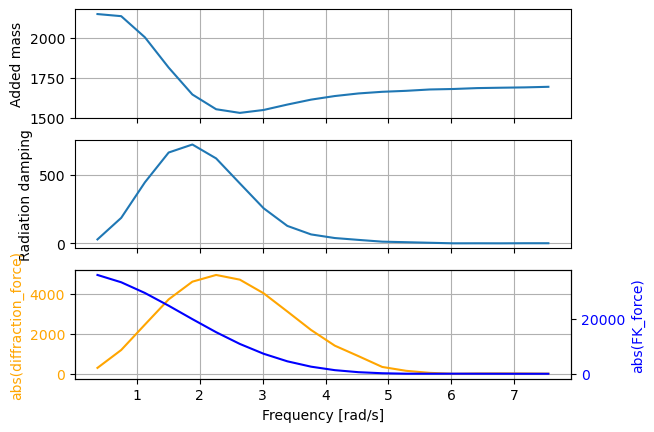

In [6]:
fig, axes = plt.subplots(3,1)
bem_data['added_mass'].plot(ax = axes[0])
bem_data['radiation_damping'].plot(ax = axes[1])
axes[2].plot(bem_data['omega'],np.abs(np.squeeze(bem_data['diffraction_force'].values)), color = 'orange')
axes[2].set_ylabel('abs(diffraction_force)', color = 'orange')
axes[2].tick_params(axis ='y', labelcolor = 'orange')
ax2r = axes[2].twinx()
ax2r.plot(bem_data['omega'], np.abs(np.squeeze(bem_data['Froude_Krylov_force'].values)), color = 'blue')
ax2r.set_ylabel('abs(FK_force)', color = 'blue')
ax2r.tick_params(axis ='y', labelcolor = 'blue')

for axi in axes:
    axi.set_title('')
    axi.label_outer()
    axi.grid()
    
axes[-1].set_xlabel('Frequency [rad/s]')

#### PTO 
The AquaHarmonics device drive train includes a generator and pneumatic air spring, each of which have distinct gearings relative to linear tether motion as well as finite levels of inertia and friction. 
Take a look at their [interactive visualization](https://aquaharmonics.com/wec_vis/) of the device and PTO system in motion.
Here, we define each of these factors so that they may be subsequently incorporated into our model.

In [7]:
radii = {
    "S1": 0.02, "S2": 0.795, "S3": 0.1595, "S4": 0.200525, "S5": 0.40105, 
    "S6": 0.12575, "S7": 0.103
}

inertias = {
    "Igen": 3.9, "I1": 0.029, "I2": 25.6, "I3": 1.43, "I4": 1.165, "I5": 4.99, 
    "I6": 1.43, "I7": 1.5, "mps": 40
}

friction = {
    "Bgen": 7, "Bdrivetrain": 40, "Bshaft": 40, "Bspring_pulley": 80, 
    "Bpneumatic_spring": 700, "Bpneumatic_spring_static1": 0, 
    "Bpspneumatic_spring_static2": 0
}

airspring = {
    "gamma": 1.4, "height": 1, "diameter": 3, "area": 0.0709676, 
    "press_init": 854e3, "vol_init": 1
}

gear_ratios = {
    "R21": radii['S2']/radii['S1'],
    "R45": radii['S4']/radii['S5'], 
    "R67": radii['S6']/radii['S7'],
    "spring": radii['S6']*(radii['S4']/radii['S5'])
}

inertia_pto = (
    (inertias["Igen"]  + inertias["I1"])*gear_ratios['R21']**2 +
    (inertias['I2'] +inertias['I3'] + inertias['I4']) +
    gear_ratios["R45"]**2 * (
        inertias['I5'] + inertias['I6'] +
        inertias["I7"] * gear_ratios['R67']**2 +
        inertias['mps'] * radii['S6']**2   
    )
)

friction_pto = (
    friction['Bgen']*gear_ratios['R21']**2 + 
    friction['Bdrivetrain'] +
    gear_ratios["R45"]**2 * (
        friction["Bshaft"]+
        friction["Bspring_pulley"]*gear_ratios['R67']**2 +
        friction["Bpneumatic_spring"]*radii['S6']**2
    )
)

##### Generator loss map
The generator used by the AquaHarmonics devices is a motor from a Nissan Leaf.
`WecOptTool` currently uses loss maps, as efficiency maps are unable to account for losses that occur when the mechanical power is zero (e.g., when the torque is nonzero, but the shaft speed is zero).
Thus, we use an [approximate model for the losses](https://en.wikipedia.org/wiki/Joule_heating) in this example.

In [8]:
winding_resistance = 0.4
torque_coefficient = 1.5

def power_loss(speed, torque):
    return winding_resistance * (torque / torque_coefficient)**2 

In addition to the loss data, the generator has some limitations, which we can capture in our model.
Specifically, this generator has the following limits:

 * Maximum rotational speed: 10,000 rpm
 * Maximum torque: 300 Nm
 * Maximum power: 80 kW

In [9]:
rot_max = 10000*2*np.pi/60 # [rad/s]
torque_max = 300 # [Nm]
power_max = 80e3 # [W]

Finally, we can plot the motor power loss surface to see how it looks.
Here, the independent variables are the motor speed in [rad/s] and the motor torque in [Nm].
Note that we limit the plot by the power limit.

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x000001DBA63193F0>


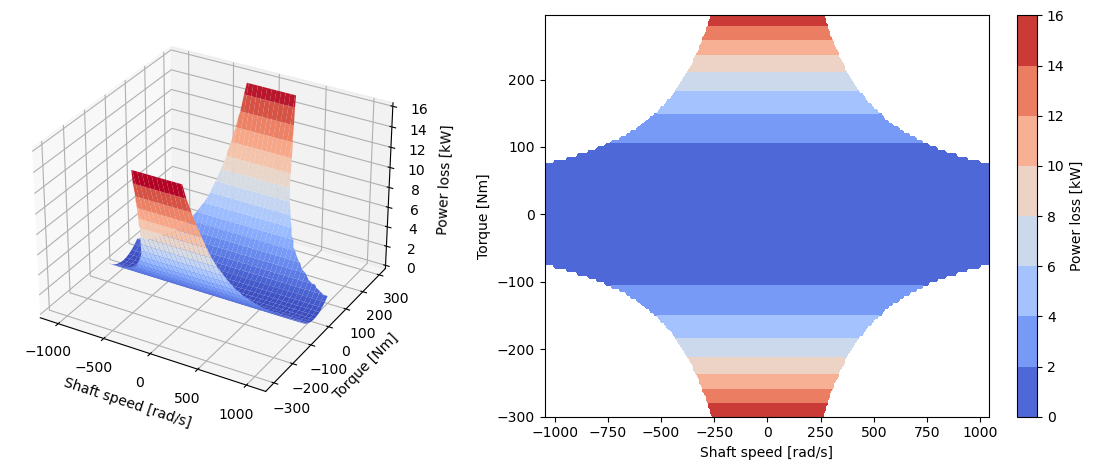

In [10]:
x = np.arange(-1*rot_max, 1*rot_max, 10)
y = np.arange(-1*torque_max, 1.0*torque_max, 5)
X, Y = np.meshgrid(x, y)
Z = power_loss(X, Y).copy()/1e3
Z[np.abs(X*Y) > power_max] = np.NaN  # cut off area outside of power limit

fig = plt.figure(figsize=plt.figaspect(0.4))
ax = [fig.add_subplot(1, 2, 1, projection="3d"),
      fig.add_subplot(1, 2, 2)]

ax[0].plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
ax[0].set_xlabel('Shaft speed [rad/s]')
ax[0].set_ylabel('Torque [Nm]')
ax[0].set_zlabel('Power loss [kW]')
# ax[0].set_zlim([0, 1.1])

contour = ax[1].contourf(X, Y, Z, cmap=cm.coolwarm)
plt.colorbar(contour, label="Power loss [kW]")
ax[1].set_xlabel('Shaft speed [rad/s]')
ax[1].set_ylabel('Torque [Nm]')

plt.tight_layout()

##### PTO object
Using both the parametric kinematics (gear ratios) and the motor power loss map, we can now create a PTO object that will be inserted in our WEC object.
Note that the friction and inertia effects will be included as additional forces.
By defining the PTO object in this way, we will be able to more clearly distinguish the power generating forces from other effects (e.g., friction).

In [11]:
name = ["PTO_Heave",]
gear_ratio_generator = gear_ratios['R21']/radii['S3']
kinematics = gear_ratio_generator*np.eye(ndof)
controller = None
nstate_opt = 2*nfreq
pto_impedance = None
pto = wot.pto.PTO(
    ndof, kinematics, controller, pto_impedance, power_loss, name
)

#### Additional Forces
In WecOptTool, hydrodynamic forces are considered automatically.
Thus to account for other phenomena we create ''**additional forces**'':

* **Buoyancy, gravity and pretension** - While the buoyancy and gravity phenomena are often lumped together, we will keep them separate here. This is useful because the AquaHarmonics devices has a pretension force, so the buoyancy and gravity forces are not balanced at the neutral position and there is a pretension force from the tether/air spring.
* **Passive PTO forces** - Inertia forces due to finite rigid body inertia of gears and friction forces within the drive train are captured by this function.
* **PTO line force** - The total force imposed on the WEC from its tether is the sum of the PTO force due to action by the generator and the pretension force from the air spring.
The generator torque will be our control state for which we will derive the optimal trajectory.

In [12]:
def f_buoyancy(wec, x_wec, x_opt, waves, nsubsteps=1):
    """Only the zeroth order component (doesn't include linear stiffness)"""
    return displacement * rho * g * np.ones([wec.ncomponents*nsubsteps, wec.ndof])

def f_gravity(wec, x_wec, x_opt, waves, nsubsteps=1):
    return -1 * wec.inertia_matrix.item() * g * np.ones([wec.ncomponents*nsubsteps, wec.ndof])

def f_pretension_wec(wec, x_wec, x_opt, waves, nsubsteps=1):
    """Pretension force as it acts on the WEC"""
    f_b = f_buoyancy(wec, x_wec, x_opt, waves, nsubsteps) 
    f_g = f_gravity(wec, x_wec, x_opt, waves, nsubsteps)
    return  -1*(f_b+f_g)

def f_pto_passive(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos = wec.vec_to_dofmat(x_wec)
    vel = np.dot(wec.derivative_mat,pos)
    acc = np.dot(wec.derivative_mat, vel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    spring = -(gear_ratios['spring']*airspring['gamma']*airspring['area']*
              airspring['press_init']/airspring['vol_init']) * pos
    f_spring = np.dot(time_matrix,spring)
    fric = -(friction_pto  + 
                friction['Bpneumatic_spring_static1']*
                gear_ratios['spring']) * vel
    f_fric = np.dot(time_matrix,fric)
    inertia = inertia_pto * acc
    f_inertia = np.dot(time_matrix,inertia)
    return f_spring + f_fric + f_inertia

def f_pto_line(wec, x_wec, x_opt, waves, nsubsteps=1):
    f_pto = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    f_pre = f_pretension_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_pto + f_pre

f_add = {'PTO': f_pto_line,
         'PTO_passive': f_pto_passive,
         'buoyancy': f_buoyancy,
         'gravity': f_gravity}

#### Constraints
A number a constraints need to be imposed to reflect finite limitation of the drive train hardware.
Each of these will be implemented as inequality constraints that will be passed to the numerical optimization solver.

Note that we are imposing the constraints at more points than the dynamics by setting `nsubsteps>1`.
This ensures that the constraint is properly maintained (see the Theory page in the WecOptTool documentation for more details).

 * **Peak torque** - The absolute motor torque cannot exceed this value.
 * **Maximum rotational speed** - The absolute motor speed cannot exceed this value.
 * **Maximum power** - The maximum mechanical power (i.e., product of torque and velocity) cannot exceed this value.
 * **Minumum line tension** - In addition to these limitations on the hardware, we will also constrain the solution to prevent the tether tension from going below a certain threshold. We absolutely cannot allow the line tension to be less than zero, or else it will go slack. In practice, it is prudent to set some nonzero limit for the tether tension.
 * **Mean torque** - While solutions with an nonzero mean positions may indeed be valid, we want to rely on a single calculation of the linear hydrodynamics at a mean position of 0. To avoid violating this approach, we will constrain the mean WEC position to zero.

In [13]:
# Generator constraints
torque_peak_max = 280  #[Nm]   
rot_speed_max = 10000*2*np.pi/60  #[rad/s]
# mooring/PTO line constraint
min_line_tension = -1000

nsubsteps = 2

def const_peak_torque_pto(wec, x_wec, x_opt, waves):
    torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps)
    return torque_peak_max - np.abs(torque.flatten())

def const_speed_pto(wec, x_wec, x_opt, waves):
    rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return rot_speed_max - np.abs(rot_vel.flatten())

def const_power_pto(wec, x_wec, x_opt, waves):
    power_mech = (
        pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) *
        pto.force(wec, x_wec, x_opt, waves, nsubsteps)
    )
    return power_max - np.abs(power_mech.flatten())

def constrain_min_tension(wec, x_wec, x_opt, waves):
    total_tension = -1*f_pto_line(wec, x_wec, x_opt, waves, nsubsteps)
    return total_tension.flatten() + min_line_tension

def zero_mean_pos(wec, x_wec, x_opt, waves):
    return x_wec[0]

constraints = [
    {'type': 'ineq', 'fun': constrain_min_tension,},
    {'type': 'ineq', 'fun': const_peak_torque_pto,},
    {'type': 'ineq', 'fun': const_speed_pto,},
    {'type': 'ineq', 'fun': const_power_pto,},
    {'type': 'eq', 'fun': zero_mean_pos},
]

#### WEC object
Finally, we can use all the different components we've developed thus far to construct a `WEC` object:

 * **BEM data** - defines the hydrodynamics of the hull and includes hydrostatics
 * **Constraints** - limitations on the hardware (max power, max torque, etc.) and the constraint to prevent the tether from going slack
 * **Additional forces** - this captures all of the forces on the WEC that are not due to the interaction between the hull and water (PTO, etc.)

In [14]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints = constraints,
    f_add = f_add,
)

### Waves
A regular wave will allow us to get a good initial understanding of the optimal control trajectory.
Note that we'll want to choose a wave frequency that is within the frequency array we used to calculate the hydrodynamic data.

In [15]:
amplitude = 0.5
wavefreq =  0.24/2 
phase = 30
wavedir = 0
waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

### Objective function
To drive the solution of the optimal control trajectory, we will optimize the average electrical power from the PTO.

In [16]:
obj_fun = pto.average_power

### Solve
Finally, we solve for the optimal control trajectory.
To ensure the numerical optimization problem is well-scaled, we set specific scaling factors for the WEC position (`scale_x_wec`), the PTO force (`scale_x_opt`), and objective function (`scale_obj`).
We will also set the [maximum iteration and objective function tolerance for the optimization solver](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html).
This step typically takes about 30s.

In [17]:
scale_x_wec = 1e1
scale_x_opt = 50e-2
scale_obj = 1e-3

options = {'maxiter': 200, 'ftol': 1e-8}

results = wec.solve(
    waves,
    obj_fun,
    nstate_opt,
    x_wec_0=np.ones(wec.nstate_wec) * 1e-3,
    x_opt_0=np.ones(nstate_opt) * 1e-3,
    optim_options=options,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)

print(f'Optimal average power: {results.fun/1e3:.2f} kW')

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 3.74e-01, -5.93e-03]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 3.74e-01, -5.93e-03]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 3.51e-01, -1.09e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.52e+00, 3.51e-01, -1.09e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.11e-01, -3.53e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.53e+00, 6.11e-01, -3.53e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 2.24e+00, -1.54e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.56e+00, 2.24e+00, -1.54e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.69e+00, 1.01e+01, -6.57e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]

INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.13e+00, 3.65e+01, -1.53e+00]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5332020907063684
            Iterations: 55
            Function evaluations: 55
            Gradient evaluations: 55
Optimal average power: -1.53 kW


### Post-process and plotting
Next, we post-process the results to allow us to more easily visualize them in a series of plots.
Note that because the `WEC` and `PTO` objects are distinct (the WEC object really only knows what the force from the PTO is, not how that force is obtained), we create two separate results objects (in each case, we get results in the frequency domain and time domain).

In [18]:
wec_fdom, wec_tdom = wec.post_process(results, waves, nsubsteps=nsubsteps)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)

We can inspect each of these [Xarray Datasets](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) for more details.
As an example the post-processed WEC time-domain results include the following:

In [19]:
wec_tdom

<xarray.Dataset>
Dimensions:         (influenced_dof: 1, time: 80, type: 9, wave_direction: 1)
Coordinates:
  * influenced_dof  (influenced_dof) <U5 'DOF_0'
  * time            (time) float64 0.0 0.2083 0.4167 0.625 ... 16.04 16.25 16.46
    omega           float64 7.54
    freq            float64 1.2
    period          float64 0.8333
  * type            (type) object 'radiation' 'friction' ... 'gravity'
  * wave_direction  (wave_direction) float64 0.0
Data variables:
    pos             (influenced_dof, time) float64 0.4352 0.4831 ... 0.3761
    vel             (influenced_dof, time) float64 0.2581 0.1991 ... 0.3102
    acc             (influenced_dof, time) float64 -0.2547 -0.2967 ... -0.2293
    force           (influenced_dof, type, time) float64 489.8 ... -4.905e+04
    wave_elev       (wave_direction, time) float64 0.433 0.3886 ... 0.4668
Attributes:
    time_created_utc:  2023-10-25 15:25:03.369676

#### Time histories
We will now generate a series of time history plots:

 * **Excitation force and velocity** - Looking at the velocity of the WEC along with the excitation force is useful as we expect the two of these to be in phase *when maximizing mechanical power and in the absence of constraints.*
 * **PTO and total mooring tether force** - Since we constrained the PTO force in order to maintain a minimum mooring tether tension, it is useful to visualize these values to confirm that the constraint was properly enforced.
 * **Generator torque** - Similarly, we constrained the maximum torque from the generator
 * **Power** - We can look at both electrical and mechanical power along with the constraint on mechanical power.

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', we

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\An

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNB.TTF', name='Arial', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 6.8986363636363635
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NIAGENG.TTF', name='Niagara Engraved', style='normal', variant='normal', we

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILC____.TTF', name='Gill Sans MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Gabriola.ttf', name='Gabriola', style='normal', var

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLB.TTF', name='Bell MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SNAP____.TTF', name='Snap ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCC____.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILLUBCD.TTF', name='Gill Sans Ultra Bold Condensed', style='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\KUNSTLER.TTF', name='Kunstler Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TEMPSITC.TTF', name='Tempus Sans ITC', style='normal', variant='normal', wei

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHIC.TTF', name='Century Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\gadugib.ttf', name='Gadugi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BASKVILL.TTF', name='Baskerville Old Face', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKI.TTF', name='Rockwell', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LEELAWDB.TTF', name='Leelawadee', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRADHITC.TTF', name='Bradley Hand ITC', style='normal', variant='normal', weight=400

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\monbaiti.ttf', name='Mongolian Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisot1.ttf', name='SWIsot1', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobemyungjostd-medium.otf',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 6.613636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguili.ttf', name='Segoe UI', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERI____.TTF', name='Perpetua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\arial.ttf', name='Arial', style='normal', variant='normal', weight=400, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 4.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCBI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisop2.ttf', name='SWIsop2', style='normal', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd-bold.otf', name='Courier Std', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKEB.TTF', name='Rockwell Extra Bold', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\framdit.ttf', name='Franklin Gothic Medium', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COLONNA.TTF', name='Colonna MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelb.ttf', name='Corbel', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambria.ttc', name='Cambria', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolaz.ttf', name='Consolas', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSDI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_PSTC.TTF', name='Bodoni MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgrekc.ttf', name='SWGrekc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisop3.ttf', name='SWIsop3', style='normal', variant='normal', weight=400, stretch='normal', s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NirmalaS.ttf', name='Nirmala UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VLADIMIR.TTF', name='Vladimir Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgdt.ttf', name='SWGDT', style='normal', variant='normal', weight=400, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibriz.ttf', name='Calibri', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRLNSDB.TTF', name='Berlin Sans FB Demi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 7.8986363636363635
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HARLOWSI.TTF', name='Harlow Solid Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swromns.ttf', name='SWRomns', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgia.ttf', name='Georgia', style='normal', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-bolditalic.otf', name='Adobe Thai', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASLGHT.TTF', name='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Use

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CHILLER.TTF', name='Chiller', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', wei

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCK.TTF', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-regular.otf', name='Adobe Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\W

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PLAYBILL.TTF', name='Playbill', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-bold.otf', name='Adobe Arabic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCY

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swcomp.ttf', name='SWComp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjh.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgreks.ttf', name='SWGreks', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCM_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyh.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKI.TTF', name='Rockwell', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuiz.ttf', name='Segoe UI', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ntailu.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrili.ttf', name='Calibri', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspa.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LATINWD.TTF', name='Wide Latin', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILLUBCD.TTF', name='Gill Sans Ultra Bold Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constanb.ttf', name='Constantia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERTIBD.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-BOLD.TTF', name='Dubai', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd-bold.otf', name='Courier Std', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKEB.

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mvboli.ttf', name='MV Boli', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelb.ttf', name='Corbel', style='normal', variant='normal', weight=700, stretch='normal', size='sc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\OLDENGL.TTF', name='Old English Text MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSDI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_PSTC.TTF', name='Bodoni MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgrekc.ttf', name='SWGrekc', style='normal', variant='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTBI.TTF', name='Calisto MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NirmalaS.ttf', name='Nirmala UI', style='normal', variant='normal', weight=350, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolab.ttf', name='Consolas', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAGE.TTF', name='Rage Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibriz.ttf', name='Calibri', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRLNSDB.TTF', name='Berlin Sans FB Demi', style='normal', variant='normal', weight=700, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CURLZ___.TTF', name='Curlz MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HARLOWSI.TTF', name='Harlow Solid Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariblk.ttf', name='Arial', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SNAP____.TTF', name='Snap ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='sc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VIVALDII.TTF', name='Vivaldi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisb.ttf', name='Segoe UI', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneral.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=italic:variant=normal:we

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.434999999999999
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fnam

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CHILLER.TTF', name='Chiller', style='normal', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRAHV.TTF', name='Franklin Gothic Heavy', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COLONNA.TTF', name='Colonna MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRSCRIPT.TTF', name='French Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCK.TTF', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CASTELAR.TTF', name='Castellar', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-regular.otf', name='Adobe Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNT

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd-oblique.otf', name='Courier Std', style='oblique', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.245
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-REGULAR.TTF', name='Dubai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrps.t

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgreks.ttf', name='SWGreks', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-bold.otf', name='Adobe Thai', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAXD.TTF', name='Lucida Fax', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PLAYBILL.TTF', name='Playbill', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCRIPTBL.TTF', name='Script

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRAMDCN.TTF', name='Franklin Gothic Medium Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arial.ttf', name='Arial', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRUSHSCI.TTF', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swcomp.ttf', name='SWComp', style='normal', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MAGNETOB.TTF', name='Magneto', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\sylfaen.ttf', name='Sylfaen', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCEDSCR.TTF', name='Edwardian Script ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPEO.TTF', name='Lucida Sans Typewriter', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.15
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRAHV.TTF', name='Franklin Gothic Heavy', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyi.ttf', name='Microsoft Yi Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCM_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MAIAN.TTF', name='Maiandra GD', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARLRDBD.TTF', name='Arial Rounded MT Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LEELAWAD.TTF', name='Leelawadee', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOS.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HARNGTON.TTF', name='Harrington', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ntailu.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=40

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\WINGDNG3.TTF', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanai.ttf', name='Verdana', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILB____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobesongstd-light.otf', name='Adobe Song Std', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GLECB.TTF', name='Gloucester MT Extra Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEnt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTI.TTF', name='Calisto MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarai.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOS.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mvboli.ttf', name='MV Boli', style='normal', variant='normal', weight=400, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICBI.TTF', name='Century Gothic', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucit.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\taile.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\OLDENGL.TTF', name='Old English Text MT', style='normal', variant='normal', weight=40

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNI.TTF', name='Arial', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisop1.ttf', name='SWIsop1', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILBI___.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consola.ttf', name='Consolas', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_BI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolab.ttf', name='Consolas', style='normal', variant='normal', weight=700, stretch='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoepr.ttf', name='Segoe Print', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisot2.ttf', name='SWIsot2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\VLADIMIR.TTF', name='Vladimir Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahomabd.ttf', name='Tahoma', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-bolditalic.otf', name='Adobe Hebrew', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariblk.ttf',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FREESCPT.TTF', name='Freestyle Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GARA.TTF', name='Garamond', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCMI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VIVALDII.TTF', name='Vivaldi', style='italic', variant='normal', weight=400, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Us

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\trebuc.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_PSTC.TTF', name='Bodoni MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozgopr6n-medium.otf', name='Kozuka Gothic Pr6N', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\wingding.ttf', name='Wingdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRAH

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSDB.TTF', name='Berlin Sans FB Demi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COLONNA.TTF', name='Colonna MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRSCRIPT.TTF', name='French Script MT', style='normal', variant='normal', weight=40

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CASTELAR.TTF', name='Castellar', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HARNGTON.TTF', name='Harrington', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd-oblique.otf', name='Courier Std', style='oblique', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRADHITC.TTF', name='Bradley Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgreks.ttf', name='SWGreks', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-bold.otf'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swastro.ttf', name='SWAstro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GIGI.TTF', name='Gigi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRAMDCN.TTF', name='Franklin Gothic Medium Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CBI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MAGNETOB.TTF', name='Magneto', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\sylfaen.ttf', name='Sylfaen', style='normal', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_R.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPEO.TTF', name='Lucida Sans Typewriter', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRAHV.TTF', name='Franklin Gothic Heavy', style='normal', variant='normal', w

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobefanheitistd-bold.otf', name='Adobe Fan Heiti Std', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanz.ttf', name='Constantia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MAIAN.TTF', name='Maiandra GD', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BSSYM7.TTF', name='Bookshelf Symbol 7', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LEELAWAD.TTF', name='Leelawadee', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\WINGDNG3.TTF', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swtxt.ttf', name='SWTxt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTI.TTF', name='Calisto MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarai.ttf', name='Candara', style='italic', variant='normal', weight=400, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CURLZ___.TTF', name='Curlz MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanb.ttf', name='Constantia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICBI.TTF', name='Century Gothic', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucit.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozminpr6n-regular.otf', name='Kozuka Mincho Pr6N', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmeteo.ttf', name='SWMeteo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNI.TTF', name='Arial', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisop1.ttf',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtextb.ttf', name='Myanmar Text', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromns.ttf', name='SWRomns', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobeheitistd-regular.otf', name='Adobe Heiti Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\sego

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahomabd.ttf', name='Tahoma', style='normal', variant='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swital.ttf', name='SWItal', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FREESCPT.TTF', name='Freestyle Script', style='normal', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozgopr6n-medium

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuib.ttf', name='Segoe UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PAPYRUS.TTF', name='Papyrus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAB.TTF', name='Book Antiqua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILBI___.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weig

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKBI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRADHITC.TTF', name='Bradley Hand ITC', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swastro.ttf', name='SWAstro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GIGI.TTF', name='Gigi', style='normal', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CBI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNT.TTF', name='Elephant', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_R.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candaral.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobefanheitistd-bold.otf', name='Adobe Fan Heiti Std', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanz.ttf', name='Constantia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUA

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BERNHC.TTF', name='Bernard MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BSSYM7.TTF', name='Bookshelf Symbol 7', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swtxt.ttf', name='SWTxt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTI.TTF', name='Calisto MT', style='italic', variant='normal', weight=4

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BAUHS93.TTF', name='Bauhaus 93', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CURLZ___.TTF', name='Curlz MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanb.ttf', name='Constantia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICBI.TTF', name='Century Gothic', style='italic', variant='normal', weight=700, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozminpr6n-regular.otf', name='Kozuka Mincho Pr6N', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmeteo.ttf', name='SWMeteo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNI.TTF', name='Arial', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisop1.ttf', n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtextb.ttf', name='Myanmar Text', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromns.ttf', name='SWRomns', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobeheitistd-regular.otf', name='Adobe Heiti Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoepr.

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahomabd.ttf', name='Tahoma', style='normal', variant='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swital.ttf', name='SWItal', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FREESCPT.TTF', name='Freestyle Script', style='normal', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\w

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozgopr6n-medium

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuib.ttf', name='Segoe UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PAPYRUS.TTF', name='Papyrus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAB.TTF', name='Book Antiqua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILBI___.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weig

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKBI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRADHITC.TTF', name='Bradley Hand ITC', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swastro.ttf', name='SWAstro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GIGI.TTF', name='Gigi', style='normal', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CBI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNT.TTF', name='Elephant', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_R.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candaral.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobefanheitistd-bold.otf', name='Adobe Fan Heiti Std', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanz.ttf', name='Constantia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUA

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BERNHC.TTF', name='Bernard MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BSSYM7.TTF', name='Bookshelf Symbol 7', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swtxt.ttf', name='SWTxt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTI.TTF', name='Calisto MT', style='italic', variant='normal', weight=4

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BAUHS93.TTF', name='Bauhaus 93', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CURLZ___.TTF', name='Curlz MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanb.ttf', name='Constantia', style='normal', variant='normal', weight=700, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozminpr6n-regular.otf', name='Kozuka Mincho Pr6N', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmeteo.ttf', name='SWMeteo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtextb.ttf', name='Myanmar Text', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromns.ttf', name='SWRomns', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobeheitistd-regular.otf', name='Adobe Heiti Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaI.ttc'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisot3.ttf', name='SWIsot3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swital.ttf', name='SWItal', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozgopr6n-medium

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuib.ttf', name='Segoe UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\couri.ttf', name='Courier New', style='italic', variant='normal', weight=400, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PAPYRUS.TTF', name='Papyrus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAB.TTF', name='Book Antiqua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILBI___.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weig

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKBI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weigh

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swastro.ttf', name='SWAstro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNT.TTF', name='Elephant', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_R.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSBI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candaral.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobefanheitistd-bold.otf', name='Adobe Fan Heiti Std', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fon

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BERNHC.TTF', name='Bernard MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BSSYM7.TTF', name='Bookshelf Symbol 7', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAR.TTF', name='Bodoni MT', style='normal', variant='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', varian

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibril.ttf', name='Calibri', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCBI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BAUHS93.TTF', name='Bauhaus 93', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CURLZ___.TTF', name='Curlz MT', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozminpr6n-regular.otf', name='Kozuka Mincho Pr6N', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmeteo.ttf', name='SWMeteo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIST.TTF', name='Calisto MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtextb.ttf', name='Myanmar Text', style='normal', variant='normal', weight=700, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEO.TTF', name='Lucida Sans Typewriter', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobeheitistd-

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palab.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisot3.ttf', name='SWIsot3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNI.TTF', name='Arial', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swital.ttf', name='SWItal', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BELLI.TTF', name='Bell MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuib.ttf', name='Segoe UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMIT.TTF', name='Franklin Gothic Demi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PAPYRUS.TTF', name='Papyrus', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUAB.TTF', name='Book Antiqua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILBI___.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weigh

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKBI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weigh

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swastro.ttf', name='SWAstro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNT.TTF', name='Elephant', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_R.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSBI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candaral.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobefanheitistd-bold.otf', name='Adobe Fan Heiti Std', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BERNHC.TTF', name='Bernard MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BSSYM7.TTF', name='Bookshelf Symbol 7', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAR.TTF', name='Bodoni MT', style='normal', variant='normal', we

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swtxt.ttf', name='SWTxt', style='normal', variant='normal', w

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTB.TTF', name='Calisto MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BAUHS93.TTF', name='Bauhaus 93', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CURLZ___.TTF', name='Curlz MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanb.ttf', name='Constantia', style='normal', variant='normal', weight=700, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCCB___.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\kozminpr6n-regular.otf', name='Kozuka Mincho Pr6N', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmeteo.ttf', name='SWMeteo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtextb.ttf', name='Myanmar Text', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromns.ttf', name='SWRomns', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobeheitistd-regular.otf', name='Adobe Heiti Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaI.ttc'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisot3.ttf', name='SWIsot3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiaz.ttf', name='Georgia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swital.ttf', name='SWItal', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITED.TTF', name='Lucida Bright', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BELLI.TTF', name='Bell MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFR.TTF', name='Californian FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MOD20.TTF', name='Modern No. 20', style='normal', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANSI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAX.TTF', name='Lucida Fax', style='normal', variant='normal', weight=400, stretch='normal', size

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCEDSCR.TTF', name='Edwardian Script ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CB.TTF', name='Bodoni MT', style='normal', variant='normal', weight=700, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ONYX.TTF', name='Onyx', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GARAIT.TTF', name='Garamond', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swromnc.ttf', name='SWRomnc', style='normal', variant='normal', weight=400, stretch='normal', size='scal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDYSTO.TTF', name='Goudy Stout', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-bold.otf', name='Adobe Hebrew', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\l_10646.ttf', name='Lucida Sans Unicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ari

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BASKVILL.TTF', name='Baskerville Old Face', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HARLOWSI.TTF', name='Harlow Solid Italic', style='italic', variant='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuiz.ttf', name='Segoe UI', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILB____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbd.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoesc.ttf', name='Segoe Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmeteo.ttf', name='SWMeteo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobemingstd-light.otf',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\holomdl2.ttf', name='HoloLens MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SHOWG.TTF', name='Showcard Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelaUIb.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOSI.TTF', name='Goudy Old Style', style='italic', variant='normal', w

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiab.ttf', name='Georgia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesi.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MSUIGHUB.TTF', name='Microsoft Uighur', style='normal', variant='normal', weigh

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consola.ttf', name='Consolas', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LeelawUI.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\switalc.ttf', name='SWItalc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYB.TTF', name='Agency FB', style='normal', variant='normal', weight=700, stretch='normal', siz

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgothi.ttf', name='SWGothi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalc.ttf', name='SWItalc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKBI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromnd.ttf', name='SWRomnd', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BAUHS93.TTF', name='Bauhaus 93', style='normal', variant='normal', weight=400, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consolaz.ttf', name='Consolas', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\courbd.ttf', name='Courier New', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmono.ttf', name='SWMono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTILI.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFR.TTF', name='Californian FB', style='normal', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-REGULAR.TTF', name='Dubai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSI.TTF', name='Goudy Old Style', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibril.ttf', name='Calibri', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothg.ttf', name='SWGothg', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ENGR.TTF', name='Engravers MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', siz

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILC____.TTF', name='Gill Sans MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyi.ttf', name='Microsoft Yi Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PLAYBILL.TTF', name='Playbill', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILB____.TTF', name='Gill Sans MT', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmap.ttf', name='SWMap', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguibli.ttf', name='Segoe UI', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OCRAEXT.TTF', name='OCR A Extended', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\holomdl2.ttf', name='HoloLens MDL2 Assets', style='normal', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MATURASC.TTF', name='Matura MT Script Capitals', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOS.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERI____.TTF', name='Perpetua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromnt.ttf', name='SWRomnt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consola.ttf', name='Consolas', style='normal', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd-boldoblique.otf', name='Courier Std', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmap.ttf', name='SWMap', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FTLTLT.TTF', name='Footlight MT Light', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgothi.ttf', name='SWGothi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalc.ttf'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swastro.ttf', name='SWAstro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\JUICE___.TTF', name='Juice ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consolaz.ttf', name='Consolas', style='italic', variant='normal', weight=700, stretch='normal', size='scala

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_CI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCMI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TEMPSITC.TTF', name='Tempus Sans ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\VIVALDII.TTF', name='Vivaldi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_B.TTF', name='Bodoni MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobepistd.otf', name='Adobe Pi Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunbd.ttf', name='Malgun Go

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\malgunbd.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyh.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-regular.otf', name='Adobe Thai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-italic.otf', name='Adobe Hebrew', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANSD.TTF', name='Lucida Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VINERITC.TTF', name='Viner Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\KUNSTLER.TTF', name='Kunstler Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITE.TTF', name='Lucida Bright', style='normal', variant='normal', weight=400

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSBI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromnc.ttf', name='SWRomnc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LATINWD.TTF', name='Wide Latin', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbi.ttf', name='Arial', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASLGHT.TTF', name='Eras Light ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothe.ttf', name='SWGothe', style='normal', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRSCRIPT.TTF', name='French Script MT', style='normal', variant='normal', weig

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTBI.TTF', name='Calisto MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITE.TTF', name='Lucida Bright', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NIAGSOL.TTF', name='Niagara Solid', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSD.TTF', name='Lucida Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCB____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASMD.TTF', name='Eras Medium ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG2.TTF', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRUSHSCI.TTF', name='Brush Script MT', style='italic', variant='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG3.TTF', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisop2.ttf', name='SWIsop2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SHOWG.TTF', name='Showcard Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BSSYM7.TTF', name='Bookshelf Symbol 7', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\bahnschrift.ttf', name='Bahnschrift', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LHANDW.TTF', name='Lucida Handwriting', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNB.TTF', name='Arial', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-regular.otf', name='Adobe Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Sitka.ttc',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candaraz.ttf', name='Candara', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FORTE.TTF', name='Forte', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAX.TTF', name='Lucida Fax', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICB.TTF', name='Century Gothic', style='normal', variant='normal', weight=700, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILI____.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmono.ttf', name='SWMono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTILI.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-REGULAR.TTF', name='Dubai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSI.TTF', name='Goudy Old Style', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibril.ttf', name='Calibri', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothg.ttf', name='SWGothg', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ENGR.TTF', name='Engravers MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', siz

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILC____.TTF', name='Gill Sans MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyi.ttf', name='Microsoft Yi Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PLAYBILL.TTF', name='Playbill', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILB____.TTF', name='Gill Sans MT', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmap.ttf', name='SWMap', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguibli.ttf', name='Segoe UI', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OCRAEXT.TTF', name='OCR A Extended', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\holomdl2.ttf', name='HoloLens MDL2 Assets', style='normal', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MATURASC.TTF', name='Matura MT Script Capitals', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOS.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERI____.TTF', name='Perpetua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromnt.ttf', name='SWRomnt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consola.ttf', name='Consolas', style='normal', variant='normal', weight=400, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARA.TTF', name='Garamond', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhl.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=290, stretch='normal', size='scalable')) = 10.1545
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothi.ttf', name='SWGothi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LHANDW.TTF', name='Lucida Handwriting', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-bolditalic.otf', name='Adobe Arabic', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Font

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GLSNECB.TTF', name='Gill Sans MT Ext Condensed Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FTLTLT.TTF', name='Footlight MT Light', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanaz.ttf', name='Verdana', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHIC.TTF', name='Century Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuib.ttf', name='Segoe UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTIBD.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\POORICH.TTF', name='Poor Richard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\INFROMAN.TTF', name='Informal Roman', style='normal', variant='normal', weight

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarali.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibri.ttf', name='Calibri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebuc.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPEB.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=600, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugib.ttf', name='Gadugi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consolab.ttf', name='Consolas', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCK.TTF', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesi.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothM.ttc', name='Yu Gothic', style='normal', variant='normal', weight=500, stretch='normal', s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOS.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIST.TTF', name='Calisto MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='normal', s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mmrtextb.ttf', name='Myanmar Text', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspa.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERBI___.TTF', name='Perpetua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NirmalaB.ttf', name='Nirmala UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PAPYRUS.TTF', name='Papyrus', style='normal', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibri.ttf', name='Calibri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRAMDCN.TTF', name='Franklin Gothic Medium Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbd.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weigh

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-LIGHT.TTF', name='Dubai', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palab.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MAIAN.TTF', name='Maiandra GD', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILSANUB.TTF', name='Gill Sans Ultra Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisot3.ttf', name='SWIsot3', style='normal', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_CB.TTF', name='Bodoni MT', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARLRDBD.TTF', name='Arial Rounded MT Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisop3.ttf', name='SWIsop3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\OCRAEXT.TTF', name='OCR A Extended', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=4

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\monbaiti.ttf', name='Mongolian Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSB.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgia.ttf', name='Georgia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCC____.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRAHVIT.TTF', name='Franklin Gothic Heavy', style='italic', variant='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Nirmala.ttf', name='Nirmala UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICBI.TTF', name='Century Gothic', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibriz.ttf', name='Calibri', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candaral.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgdt.ttf', name='SWGDT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICB.TTF', name='Century Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\l_10646.ttf', name='Lucida Sans Unicode', style='normal', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTILI.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFR.TTF', name='Californian FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-REGULAR.TTF', name='Dubai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANSI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCEDSCR.TTF', name='Edwardian Script ITC', style='normal', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSI.TTF', name='Goudy Old Style', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', wei

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibril.ttf', name='Calibri', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothg.ttf', name='SWGothg', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDYSTO.TTF', name='Goudy Stout', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ENGR.TTF', name='Engravers MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyi.ttf', name='Microsoft Yi Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PLAYBILL.TTF', name='Playbill', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILB____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbd.ttf', name='Courier New', style='normal', variant='normal', weight=700, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguibli.ttf', name='Segoe UI', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OCRAEXT.TTF', name='OCR A Extended', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\holomdl2.ttf', name='HoloLens MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SHOWG.TTF', name='Showcard Gothic', style='normal', variant='normal', weight=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOS.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromnt.ttf', name='SWRomnt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consola.ttf', name='Consolas', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LeelawUI.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=400, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCMI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TEMPSITC.TTF', name='Tempus Sans ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', wei

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobepistd.otf', name='Adobe Pi Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunbd.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuib.ttf', name='Segoe

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-regular.otf', name='Adobe Thai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-italic.otf', name='Adobe Hebrew', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swcomp.ttf', name='SWComp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMIT.TTF', name='Franklin Gothic Demi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.f

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\KUNSTLER.TTF', name='Kunstler Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITE.TTF', name='Lucida Bright', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADM.TTF', name='Franklin Gothic Demi', style='normal', variant='normal', weight=4

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromnc.ttf', name='SWRomnc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LATINWD.TTF', name='Wide Latin', style='normal', variant='normal', weight=400, stretch='expanded', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKBI.TTF', name='Century Schoolbook', style='italic', variant='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASLGHT.TTF', name='Eras Light ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothe.ttf', name='SWGothe', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyhbd.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=700, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRSCRIPT.TTF', name='French Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITE.TTF', name='Lucida Bright', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NIAGSOL.TTF', name='Niagara Solid', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITEDI.TTF', name='Lucida Bright', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNT.TTF', name='Elephant', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASMD.TTF', name='Eras Medium ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG2.TTF', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRUSHSCI.TTF', name='Brush Script MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSBI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=70

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\bahnschrift.ttf', name='Bahnschrift', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LHANDW.TTF', name='Lucida Handwriting', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRABKIT.TTF', name='Franklin Gothic Book', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', we

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NIAGENG.TTF', name='Niagara Engraved', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swlink.ttf', name='SWLink', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\JUICE___.TTF', name='Juice ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-regular.otf', name='Adobe Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palabi.ttf', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Gabriola.ttf', name='Gabriola', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candaraz.ttf', name='Candara', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FORTE.TTF', name='Forte', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAX.TTF', name='Lucida Fax', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILI____.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmono.ttf', name='SWMono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTILI.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=300, stretch=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILLUBCD.TTF', name='Gill Sans Ultra Bold Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-REGULAR.TTF', name='Dubai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FORTE.TTF', name='Forte', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MSUIGHUR.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TEMPSITC.TTF', name='Tempus Sans ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSI.TTF', name='Goudy Old Style', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\gadugib.ttf', name='Gadugi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibril.ttf', name='Calibri', style='normal', variant='normal', weight=300, stretch='normal', siz

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRADHITC.TTF', name='Bradley Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisot1.ttf', name='SWIsot1', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobemyungjostd-medium.otf', name='Adobe Myungjo Std', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILC____.TTF', name='Gill Sans MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WIN

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERI____.TTF', name='Perpetua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\arial.ttf', name='Arial', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmap.ttf', name='SWMap', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguibli.ttf', name='Segoe UI', style='italic', variant='normal', weight=900, stretch='normal', size='scalabl

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCBI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisop2.ttf', name='SWIsop2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MATURASC.TTF', name='Matura MT Script Capitals', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOS.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COLONNA.TTF', name='Colonna MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_CR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERI____.TTF', name='Perpetua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PALSCRI.TTF', name='Palace Script MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\arialbd.ttf', name='Arial', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailub.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd-boldoblique.otf', name='Courier Std', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmap.ttf', name='SWMap', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FTLTLT.TT

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisop3.ttf', name='SWIsop3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\hyswlongfangsong.ttf', name='HYSWLongFangSong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swastro.ttf', name='SWAstro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgdt.ttf', name='SWGDT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanaz.ttf', name='Verdana', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\3ds Light.otf', name='3ds', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyhl.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=290, stretch='normal', size='scalable')) = 10.1545
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\malgun.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=400, stretch='normal', s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRAHVIT.TTF', name='Franklin Gothic Heavy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRADMCN.TTF', name='Franklin Gothic Demi Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_CBI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANSDI.TTF', name='Lucida Sans', style='italic', variant='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgia.ttf', name='Georgia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKI.TTF', name='Rockwell', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXD.TTF', name='Lucida Fax', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\sylfaen.ttf', name='Sylfaen', style='normal', variant='normal', weight=400, stretch='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASLGHT.TTF', name='Eras Light ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLI.TTF', name='Bell MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTEXTRA.TTF', name='MT Extra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ENGR.TTF', name='Engravers MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\w

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNB.TTF', name='Arial', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NIAGENG.TTF', name='Niagara Engraved', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swlink.ttf', name='SWLink', style='normal', variant='normal', weight=400, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILC____.TTF', name='Gill Sans MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Gabriola.ttf', name='Gabriola', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candaraz.ttf', name='Candara', style='italic', var

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILI____.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLB.TTF', name='Bell MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SNAP____.TTF', name='Snap ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCC____.TTF', name='Rockwell Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILLUBCD.TTF', name='Gill Sans Ultra Bold Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NirmalaS.ttf', name='Nirmala UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIGI.TTF', name='Gigi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFB.TTF', name='Californian FB', style='normal', variant='normal', weight=700, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\U

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\JUICE___.TTF', name='Juice ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-regular.otf', name='Adobe Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgdt.tt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FORTE.TTF', name='Forte', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAX.TTF', name='Lucida Fax', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICB.TTF', name='Century Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=400, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swmono.ttf', name='SWMono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTILI.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFR.TTF', name='Californian FB', style='normal', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ALGER.TTF', name='Algerian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-REGULAR.TTF', name='Dubai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSAN.TTF', name='MS Reference Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSI.TTF', name='Goudy Old Style', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENTURY.TTF', name='Century', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibril.ttf', name='Calibri', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothg.ttf', name='SWGothg', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ENGR.TTF', name='Engravers MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', siz

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXDI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\tahoma.ttf', name='Tahoma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILC____.TTF', name='Gill Sans MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCBLKAD.TTF', name='Blackadder ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msyi.ttf', name='Microsoft Yi Baiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PLAYBILL.TTF', name='Playbill', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GILB____.TTF', name='Gill Sans MT', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-bolditalic.otf', name='Adobe Thai', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASLGHT.TTF', name='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching cmss10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmss10 ('C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmss10.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching cmex10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Us

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CHILLER.TTF', name='Chiller', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stre

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', wei

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCK.TTF', name='Rockwell', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-regular.otf', name='Adobe Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\W

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PLAYBILL.TTF', name='Playbill', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-bold.otf', name='Adobe Arabic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCY

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swcomp.ttf', name='SWComp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjh.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgreks.ttf', name='SWGreks', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCM_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisbi.ttf', name='Segoe UI', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyh.ttc', name='Microsoft YaHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ROCKI.TTF', name='Rockwell', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuiz.ttf', name='Segoe UI', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKB.TTF', name='Rockwell', style='normal', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANSDI.TTF', name='Lucida Sans', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swromnt.ttf', name='SWRomnt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MISTRAL.TTF', name='Mistral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelb.ttf', name='Corbel', style='normal', variant='normal', weight=700, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILSANUB.TTF', name='Gill Sans Ultra Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msgothic.ttc', name='MS Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NIAGSOL.TTF', name='Niagara Solid', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEBO.TTF', name='Lucida Sans Typewriter', style='oblique', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CHILLER.TTF', name='Chiller', style='normal', variant='normal', we

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NirmalaS.ttf', name='Nirmala UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIGI.TTF', name='Gigi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFB.TTF', name='Californian FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Use

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-regular.otf', name='Adobe Hebrew', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palabi.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgdt.ttf', name='SWGDT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LCALLIG.TTF', n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LFAX.TTF', name='Lucida Fax', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COOPBL.TTF', name='Cooper Black', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICB.TTF', name='Century Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LFAXI.TTF', name='Lucida Fax', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PERTILI.TTF', name='Perpetua Titling MT', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LCALLIG.TTF', name='Lucida Calligraphy', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFR.TTF', name='Californian FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriai.ttf', name='Cambria', style='italic', variant='normal', weight=4

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuisl.ttf', name='Segoe UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-REGULAR.TTF', name='Dubai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDOSB.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmusic.ttf', name='SWMusic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swscrpc.ttf', name='SWScrpc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ANTQUAI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ITCEDSCR.TTF', name='Edwardian Script ITC', style='normal', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOSI.TTF', name='Goudy Old Style', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbi.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', wei

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibril.ttf', name='Calibri', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothg.ttf', name='SWGothg', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GIL_____.TTF', name='Gill Sans MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDYSTO.TTF', name='Goudy Stout', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ENGR.TTF', name='Engravers MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRLNSDB.TTF', name='Berlin Sans FB Demi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRAHVIT.TTF', name='Franklin Gothic Heavy', style='italic', variant='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swromns.ttf', name='SWRomns', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgia.ttf', name='Georgia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-bolditalic.otf', name='Adobe Thai', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASLGHT.TTF', name='Eras Light ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLI.TTF', name='Be

DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.434999999999999
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CHILLER.TTF', name='Chiller', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-regular.otf', name='Adobe Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLB.TTF', name='Bell MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Font

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-bold.otf', name='Adobe Arabic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\KUNSTL

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjh.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHIC.TTF', name='Century Gothic', style='normal', variant='normal', weight=400, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgreks.ttf', name='SWGreks', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BASKVILL.TTF', name='Baskerville Old Face', style='normal', variant='normal', weight=400, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibli.ttf', name='Segoe UI', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothM.ttc', name='Yu Gothic', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FREESCPT.TTF', name='Freestyle Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIST.TTF', name='Calisto MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\RAVIE.TTF', name='Ravie', style='normal', variant='normal', weight=400, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Nirmala.ttf', name='Nirmala UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_CR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\trebucit.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LTYPEO.TTF', name='Lucida Sans Typewriter', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.15
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\framd.ttf', name='Franklin Gothic Medium', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GLSNECB.TTF', name='Gill Sans MT Ext Condensed Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\framdit.ttf', name='Franklin Gothic Medium', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palab.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisot3.ttf', name='SWIsot3', style='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swromnd.ttf', name='SWRomnd', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_BLAR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS\\HoopsPublish\\resource\\Font\\myriadcad.otf', name='Myriad CAD', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNI.TTF', name='Arial', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiaz.ttf', name='Georgia', styl

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MOD20.TTF', name='Modern No. 20', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\bahnschrift.ttf', name='Bahnschrift', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BELLI.TTF', name='Bell MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FELIXTI.TTF', name='Felix Titling', style='normal', variant='normal', weight=400, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCMI____.TTF', name='Tw Cen MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TEMPSITC.TTF', name='Tempus Sans ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobepistd.otf', name='Adobe Pi Std', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunbd.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuib.ttf', name='Seg

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-regular.otf', name='Adobe Thai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobehebrew-italic.otf', name='Adobe Hebrew', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swcomp.ttf', name='SWComp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRADMIT.TTF', name='Franklin Gothic Demi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VINERITC.TTF', name='Viner Hand ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\KUNSTLER.TTF', name='Kunstler Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LBRITE.TTF', name='Lucida Bright', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candarab.ttf', name='Candara', style='normal', variant='normal', weight=7

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOOKOSBI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCCM____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swromnc.ttf', name='SWRomnc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LATINWD.TTF', name='Wide Latin', style='normal', variant='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\arialbi.ttf', name='Arial', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASLGHT.TTF', name='Eras Light ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgothe.ttf', name='SWGothe', style='normal', variant='normal', weight=400, stretc

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HATTEN.TTF', name='Haettenschweiler', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRSCRIPT.TTF', name='French Script MT', style='normal', variant='normal', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CALISTBI.TTF', name='Calisto MT', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swmath.ttf', name='SWMath', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LBRITE.TTF', name='Lucida Bright', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NIAGSOL.TTF', name='Niagara Solid', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LSANSD.TTF', name='Lucida Sans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCB____.TTF', name='Tw Cen MT Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASMD.TTF', name='Eras Medium ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG2.TTF', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRUSHSCI.TTF', name='Brush Script MT', style='italic', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\WINGDNG3.TTF', name='Wingdings 3', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TCB_____.TTF', name='Tw Cen MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swisop2.ttf', name='SWIsop2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuil.ttf', name='Segoe UI', style='normal', variant='normal', weight=300, str

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SHOWG.TTF', name='Showcard Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BSSYM7.TTF', name='Bookshelf Symbol 7', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\bahnschrift.ttf', name='Bahnschrift', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LHANDW.TTF', name='Lucida Handwriting', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNB.TTF', name='Arial', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\courierstd.otf', name='Courier Std', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailu.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibril.ttf', na

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\AGENCYB.TTF', name='Agency FB', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MSUIGHUB.TTF', name='Microsoft Uighur', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NirmalaB.ttf', name='Nirmala UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARAIT.TTF', name='Garamond', style='italic', variant='normal', weight=400, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisb.ttf', name='Segoe UI', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OLDENGL.TTF', name='Old English Text MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-italic.

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\JOKERMAN.TTF', name='Jokerman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgothg.ttf', name='SWGothg', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibli.ttf', name='Segoe UI', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothM.ttc', name='Yu Gothic', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FREESCPT.TTF', name='Freestyle Script', style='normal', variant='normal', weight=400, stretch='no

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoepr.ttf', name='Segoe Print', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhl.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=290, stretch='normal', size='scalable')) = 10.4395
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Nirmala.ttf', name='Nirmala UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_CR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\trebucit.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\myriadpro-regular.otf', name='Myriad Pro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\framd.ttf', name='Franklin Gothic Medium', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GLSNECB.TTF', name='Gill Sans MT Ext Condensed Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSB.TTF', name='Bookman Old Style', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiab.ttf', name='Georgia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BERNHC.TTF', name='Bernard MT Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swromnd.ttf', name='SWRomnd', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_BLAR.TTF', name='Bodoni MT', style='normal', variant='normal', weight=90

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\courbi.ttf', name='Courier New', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NirmalaS.ttf', name='Nirmala UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\VLADIMIR.TTF', name='Vladimir Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgdt.ttf', name='SWGDT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanaz.ttf', name='Verdana', style='italic', variant='normal', weight=700, stretch='norm

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LeelUIsl.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRLNSDB.TTF', name='Berlin Sans FB Demi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\FRAHVIT.TTF', name='Franklin Gothic Heavy', style='italic', variant='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\HTOWERT.TTF', name='High Tower Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swromns.ttf', name='SWRomns', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgia.ttf', name='Georgia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swsimp.ttf', name='SWSimp', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ebrima.ttf', name='Ebrima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobethai-bolditalic.otf', name='Adobe Thai', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASLGHT.TTF', name='Eras Light ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLI.TTF', name='Be

DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans Mono:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans Mono ('C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans Display:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\jtgrasb\\Anaconda3\\envs\\wecopttool2_0_0\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\marlett.ttf', name='Marlett', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\CHILLER.TTF', name='Chiller', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\OUTLOOK.TTF', name='MS Outlook', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='norma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PRISTINA.TTF', name='Pristina', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\PARCHM.TTF', name='Parchment', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal'

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\switalt.ttf', name='SWItalt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SCHLBKB.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BRLNSR.TTF', name='Berlin Sans FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-regular.otf', name='Adobe Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ELEPHNTI.TTF', name='Elephant', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\olfsimplesansoc-regular.ttf', name='OLF SimpleSansOC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELLB.TTF', name='Bell MT', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Font

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swscrps.ttf', name='SWScrps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\gadugi.ttf', name='Gadugi', style='normal', variant='normal', weight=400, stretch='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCRIPTBL.TTF', name='Script MT Bold', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Program Files\\SOLIDWORKS Corp\\SOLIDWORKS Electrical\\PdfLibraryResource\\font\\adobearabic-bold.otf', name='Adobe Arabic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\KUNSTL

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LSANS.TTF', name='Lucida Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjh.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHIC.TTF', name='Century Gothic', style='normal', variant='normal', weight=400, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swgreks.ttf', name='SWGreks', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Inkfree.ttf', name='Ink Free', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothB.ttc', name='Yu Gothic', style='normal', variant='normal', weight=700, stretch='normal

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgothe.ttf', name='SWGothe', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swgrekc.ttf', name='SWGrekc', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\WINGDNG2.TTF', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERBI___.TTF', name='Perpetua', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size=

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swtxt.ttf', name='SWTxt', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\swlink.ttf', name='SWLink', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constanz.ttf', name='Constantia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NIAGENG.TTF', name='Niagara Engraved', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPEBO.TTF', name='Lucida Sans Typewriter', style='oblique', variant='normal', weight=600, stret

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ntailub.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candarai.ttf', name='Candara', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\YuGothL.ttc', name='Yu Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothL.ttc', name='Yu Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOUDYSTO.TTF', name='Goudy Stout', style='normal', variant='normal', weight=400, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjh.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICB.TTF', name='Century Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\swisot2.ttf', name='SWIsot2', style='normal', variant='normal', weight=400, stretch='

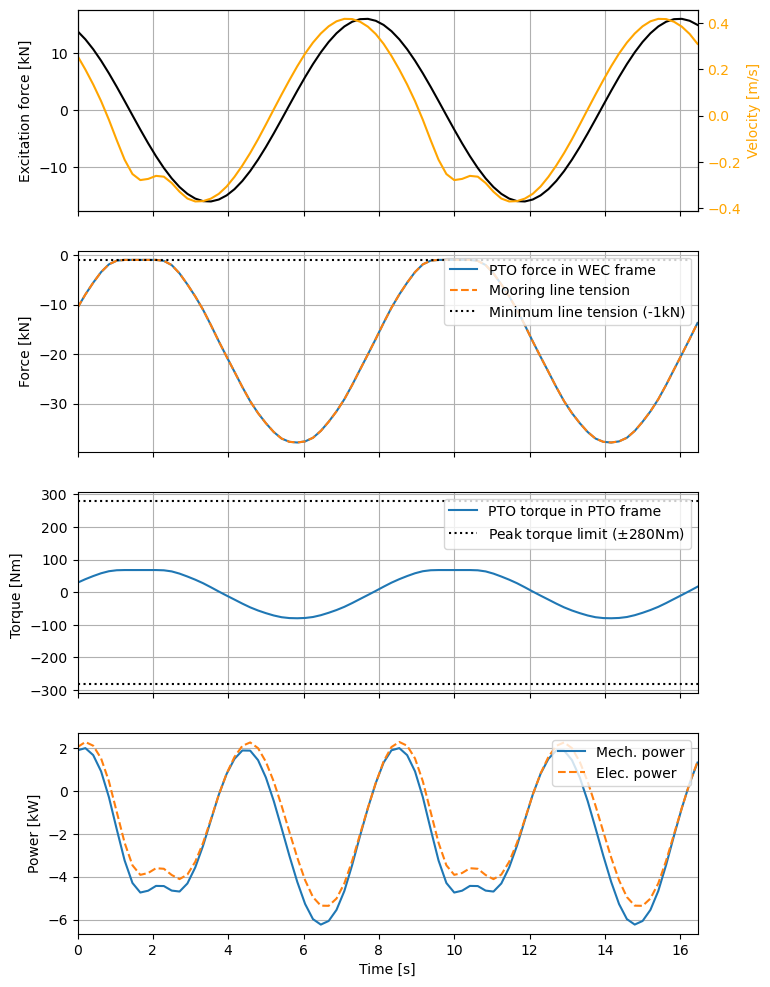

In [20]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 12))

# Excitation and velocity
ax1 = ax[0].twinx()
force_excitation = wec_tdom.force.sel(type=['Froude_Krylov', 'diffraction'])
force_excitation = force_excitation.sum('type')/1e3
force_excitation.plot(ax=ax[0], color='k')
wec_tdom.vel.plot(ax=ax1, color='orange')
ax1.set_ylabel('Velocity [m/s]', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_title('')
ax1.autoscale(enable=True, axis='x', tight=False)
ax[0].set_ylabel('Excitation force [kN]')

# Forces
(wec_tdom.force.sel(type='PTO')/1e3).plot(
    ax=ax[1], 
    label='PTO force in WEC frame',
)
x_wec, x_opt = wot.decompose_state(results.x, ndof=ndof, nfreq=nfreq)
ax[1].plot(
    wec.time_nsubsteps(nsubsteps),
    f_pto_line(wec, x_wec, x_opt, waves, nsubsteps)/1e3,
    linestyle='dashed', 
    label='Mooring line tension',
)
ax[1].plot(
    wec.time, 
    min_line_tension * np.ones(wec.time.shape) / 1e3,
    linestyle='dotted', 
    color='black',
    label=f'Minimum line tension ({min_line_tension/1e3:.0f}kN)',
)
ax[1].axhline(y=0, xmin=0, xmax=1, color='0.75', linewidth=0.5)
ax[1].set_ylabel('Force [kN]')
ax[1].legend(loc=1)

# Torque
pto_tdom.force.plot(
    ax=ax[2], 
    linestyle='solid',
    label='PTO torque in PTO frame',
)
ax[2].plot(
    pto_tdom.time, 
    1*torque_peak_max * np.ones(pto_tdom.time.shape),
    color='black', 
    linestyle='dotted',
    label=f'Peak torque limit ($\pm${torque_peak_max}Nm)',
)
ax[2].plot(
    pto_tdom.time, 
    -1*torque_peak_max * np.ones(pto_tdom.time.shape), 
    color='black', 
    linestyle='dotted',
)
ax[2].set_ylabel('Torque [Nm] ')
ax[2].legend(loc='upper right',)

# Power
(pto_tdom['power'].loc['mech',:,:]/1e3).plot(ax=ax[3], label='Mech. power')
(pto_tdom['power'].loc['elec',:,:]/1e3).plot(ax=ax[3], linestyle='dashed', 
                             label="Elec. power")
# ax[3].axhline(-1*power_max/1e3, linestyle='dotted', color='black', 
    # label=f'Max mech. power ($\pm${power_max/1e3:.0f}kW)')
# ax[3].axhline(1*power_max/1e3, linestyle='dotted', color='black')
ax[3].grid(color='0.75', linestyle='-', linewidth=0.5, axis='x')
ax[3].legend(loc='upper right')
ax[3].set_title('')
ax[3].set_ylabel('Power [kW]')

for axi in ax:
    axi.set_title('')
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)


#### Generator torque vs. shaft speed
An important factor in this study was the motor loss map that we defined for the generator.
We can visualize how the optimal control trajectory looks in state-space along with that loss map.

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x000001DBA6711390>


Text(0.5, 0, 'Shaft speed [rad/s]')

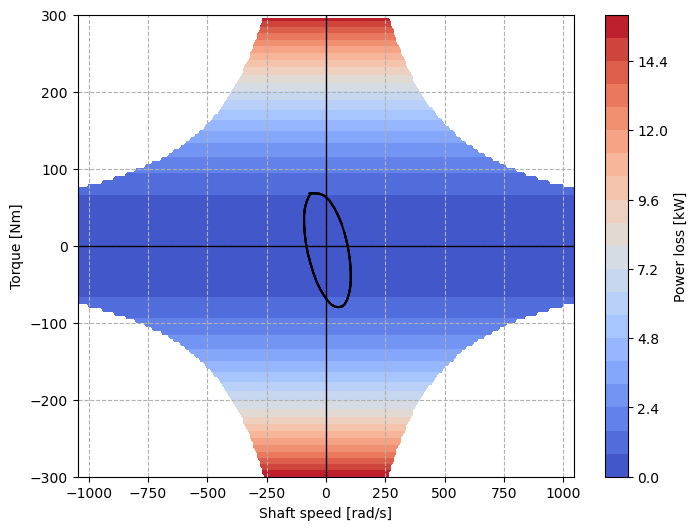

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(pto_tdom.vel, pto_tdom.force, color='k')
contour = ax.contourf(X, Y, Z, levels=20, cmap=cm.coolwarm)
plt.colorbar(contour, label="Power loss [kW]")
ax.grid(which='major', linestyle='--')
ax.axvline(0, color='k', lw=1)
ax.axhline(0, color='k', lw=1)
ax.set_ylim([-torque_max, torque_max])
ax.set_ylabel('Torque [Nm]')
ax.set_xlabel('Shaft speed [rad/s]')

## 2. Control co-design of line pre-tension/ballast
[Part 1](#1.-Optimal-control-with-a-loss-map) of this tutorial set up the model and solved for the optimal control trajectory of a single fixed device design.
We now will do control co-design to answer a real, practical question the designers have about the AquaHarmonics design:
**How big of an effect does the mass vs. line pre-tension have on the output power?** 

To do this study we will define the maximum mass as the mass that results in the pre-tension being equal to the minimum pretension, and define that as a mass ratio of `1`.
Note that this maximum mass is slightly smaller than the displaced mass, in order to maintain some positive net buoyancy and thus achieve the minimum line tension.
We will then consider different designs consisting of different mass ratios and see how the output power varies. 
For each design the optimal controller for that design will be found (as in [Part 1](#1.-Optimal-control-with-a-loss-map))

### Problem setup
The first step is to create a function that encapsulates solving for the optimal control trajectory to maximize power (i.e., [Part 1](#1.-Optimal-control-with-a-loss-map) of this tutorial) as an inner loop nested within an outer loop that varies the mass ratio.
To accomplish this, we will create a function which takes the mass fraction as an input and returns the average electrical power as an output.
We consider the same regular wave operational condition as in [Part 1](#1.-Optimal-control-with-a-loss-map). 

In [22]:
global max_torque 
max_torque = []

def design_obj_fun(x):
    global n
    n += 1

    # Unpack geometry variables
    mass_ratio = x[0]
    mass_var = mass_ratio * max_mass
    bem_data['inertia_matrix'] = mass_var
    
    # update WEC 
    wec_mass = wot.WEC.from_bem(
        bem_data,
        constraints = constraints,
        friction = None,
        f_add = f_add,
    )

    # Solve
    print(f'\nRun {n} of {N+1}: Mass ratio: {mass_ratio:.2f}')
    res = wec_mass.solve(
        waves, 
        obj_fun, 
        nstate_opt, 
        optim_options=options, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj)
    opt_average_power = res.fun
    print(
        f'* Mass: {mass_var:.2f} kg\n' +
        f'* Optimal average electrical power: {opt_average_power/1e3:.2f} kW' 
    )

    # wec_fdom, wec_tdom = wec_mass.post_process(res, waves, nsubsteps=nsubsteps)
    global max_torque 
    x_wec, x_opt = wot.decompose_state(res.x, ndof=ndof, nfreq=nfreq)
    max_torque.append(np.max(f_pto_line(wec_mass, x_wec, x_opt, waves, nsubsteps)))
    
    return res.fun

### Solve
We can now pass our function to an optimization algorithm of our choice to determine the optimal mass ratio.
Here, because the problem is fairly small and it is instructive to see the trends in the design space, we will use a [brute force optimization algorithm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html) to evaluate 7 values of mass ratio between 0.3 and 1.0.
Note that this step will take some time to complete.

In [23]:
# define range
min_ten = -1000
max_mass = (min_ten/g + displaced_mass).item()
global n; n = 0 
global N; N = 7 
min_mass_ratio = 0.3
max_mass_ratio = 1.0
mass_vals = np.linspace(min_mass_ratio, max_mass_ratio, N, endpoint=False)
ranges = (slice(
    mass_vals[0], mass_vals[-1]+np.diff(mass_vals)[0], np.diff(mass_vals)[0]
    ),
)

# solve
res = brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None)

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:Solving pseudo-spectral control problem.



Run 1 of 8: Mass ratio: 0.30


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 2.63e+00, 5.90e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 2.63e+00, 5.90e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 2.62e+00, 5.35e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.29e+00, 2.62e+00, 5.35e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.30e+00, 2.56e+00, 2.64e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.30e+00, 2.56e+00, 2.64e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.33e+00, 2.96e+00, -1.03e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.33e+00, 2.96e+00, -1.03e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 1.02e+01, -6.20e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 1.02e+01, -6.20e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.88e+00, 3.00e+01, -1.22e+00]
INFO:

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.525590901966214
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32
* Mass: 2018.81 kg
* Optimal average electrical power: -1.53 kW

Run 2 of 8: Mass ratio: 0.40


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 3.61e+00, 5.64e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 3.61e+00, 5.64e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 3.59e+00, 5.05e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 3.59e+00, 5.05e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.45e+00, 3.48e+00, 2.13e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.45e+00, 3.48e+00, 2.13e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 2.94e+00, -1.17e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.48e+00, 2.94e+00, -1.17e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 1.01e+01, -6.40e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 1.01e+01, -6.40e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 2.49e+01, -1.07e+00]
INFO:

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.537679894768766
            Iterations: 37
            Function evaluations: 37
            Gradient evaluations: 37
* Mass: 2691.74 kg
* Optimal average electrical power: -1.54 kW

Run 3 of 8: Mass ratio: 0.50


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 2.04e+00, 1.88e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 2.04e+00, 1.88e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 2.03e+00, 1.82e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 2.03e+00, 1.82e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.58e+00, 2.00e+00, 1.49e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.58e+00, 2.00e+00, 1.49e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 1.82e+00, -5.91e-03]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.60e+00, 1.82e+00, -5.91e-03]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 8.28e+00, -5.51e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.70e+00, 8.28e+00, -5.51e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.86e+00, 1.97e+01, -8.63e-01]
INFO:

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5498523672457767
            Iterations: 42
            Function evaluations: 42
            Gradient evaluations: 42
* Mass: 3364.68 kg
* Optimal average electrical power: -1.55 kW

Run 4 of 8: Mass ratio: 0.60


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 2.04e+00, 1.03e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 2.04e+00, 1.03e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 2.02e+00, 9.47e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 2.02e+00, 9.47e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 1.89e+00, 5.40e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.41e+00, 1.89e+00, 5.40e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 3.12e+00, -1.26e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.44e+00, 3.12e+00, -1.26e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 9.69e+00, -5.60e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.57e+00, 9.69e+00, -5.60e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.61e+00, 1.19e+01, -5.92e-01]
INFO:

INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.19e+00, 4.23e+01, -1.56e+00]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.5621090312068335
            Iterations: 84
            Function evaluations: 84
            Gradient evaluations: 84
* Mass: 4037.61 kg
* Optimal average electrical power: -1.56 kW

Run 5 of 8: Mass ratio: 0.70


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 3.11e+00, 2.69e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 3.11e+00, 2.69e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 3.09e+00, 2.56e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.19e+00, 3.09e+00, 2.56e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+00, 2.95e+00, 1.97e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.20e+00, 2.95e+00, 1.97e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.24e+00, 2.57e+00, -4.14e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.24e+00, 2.57e+00, -4.14e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.35e+00, 6.99e+00, -3.31e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.35e+00, 6.99e+00, -3.31e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.35e+00, 7.14e+00, -3.38e-01]
INFO:

INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 3.99e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.17e+00, 4.00e+01, -1.57e+00]

INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.18e+00, 4.00e+01, -1.57e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:Solving pseudo-spectral control problem.


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.566059184250206
            Iterations: 92
            Function evaluations: 92
            Gradient evaluations: 92
* Mass: 4710.55 kg
* Optimal average electrical power: -1.57 kW

Run 6 of 8: Mass ratio: 0.80


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 2.63e+00, 2.25e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.50e+00, 2.63e+00, 2.25e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 2.57e+00, 2.11e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 2.57e+00, 2.11e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 2.29e+00, 1.42e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.51e+00, 2.29e+00, 1.42e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 2.68e+00, -1.15e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.54e+00, 2.68e+00, -1.15e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.59e+00, 5.74e+00, -3.17e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.59e+00, 5.74e+00, -3.17e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.59e+00, 5.88e+00, -3.24e-01]
INFO:

INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [4.04e+00, 3.09e+01, -1.43e+00]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4271196654437113
            Iterations: 86
            Function evaluations: 87
            Gradient evaluations: 86
* Mass: 5383.48 kg
* Optimal average electrical power: -1.43 kW

Run 7 of 8: Mass ratio: 0.90


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.93e+00, 2.16e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.93e+00, 2.16e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.93e+00, 2.06e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.93e+00, 2.06e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.92e+00, 1.57e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.83e+00, 1.92e+00, 1.57e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 2.05e+00, -4.36e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.85e+00, 2.05e+00, -4.36e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.00e+00, -3.23e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.00e+00, -3.23e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 6.09e+00, -3.32e-01]
INFO:

INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 1.80e+01, -9.99e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.90e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.79e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.79e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.79e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.91e+00, 1.79e+01, -1.00e+00]

INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.89e+00, 1.80e+01, -1.00e+00]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9997843506068483
            Iterations: 99
            Function evaluations: 99
            Gradient evaluations: 99
* Mass: 6056.42 kg
* Optimal average electrical power: -1.00 kW

Run 8 of 8: Mass ratio: 1.00


INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 2.53e-13, -9.74e-15]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 2.53e-13, -9.74e-15]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 5.45e-14, -4.18e-15]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [3.66e+00, 5.45e-14, -4.18e-15]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.1811879905646595e-15
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
* Mass: 6729.35 kg
* Optimal average electrical power: -0.00 kW


### Results
The following plot shows the average electrical power (blue) for each of the seven designs considered along with the mean position of the device.
As the mass ratio is decreased (i.e., ballast removed), the generated power increases -- recall that negative power is power absorbed.
In this wave, the most power is generated when the mass fraction is 0.7.
This is a scenario when the ballast is such that the total rigid body mass is 70% of the maximum, which allows for a pretension that is approximately 21 times the minimum pretension.

As the mass fraction is increased, pre-tension approaches the minimum line tension.
At the limit (mass fraction of unity), the WEC can produce no power, as any action by the motor would slack the mooring line (recall that we forced the solution be symmetric).
Recall from the results in [Part 1](#1.-Optimal-control-with-a-loss-map) that we observed the motor torque saturating to avoid violating the minimum line tension constraint.
The red curve corresponding to the y-axis on the right-hand side of the plot shows the minimum absolute line tension.
We can see that for mass fractions equal to and greater than 0.7 the line tension reaches the minimum value, thus bringing that constraint into effect and limiting the generated power.

Below a mass fraction of 0.7, we see a slight decrease in generated power.
As we decrease the mass ($m$), we are increasing the natural frequency ($\omega_n$), and increasingly detuning the device with respect to the incoming waves.

$$
\omega_n = \sqrt{\frac{k}{m}}
$$

Thus we have at least two competing factors (maintaining the minimum line tension vs. aligning the natural frequency of the device to incoming waves), that produce the result seen below.

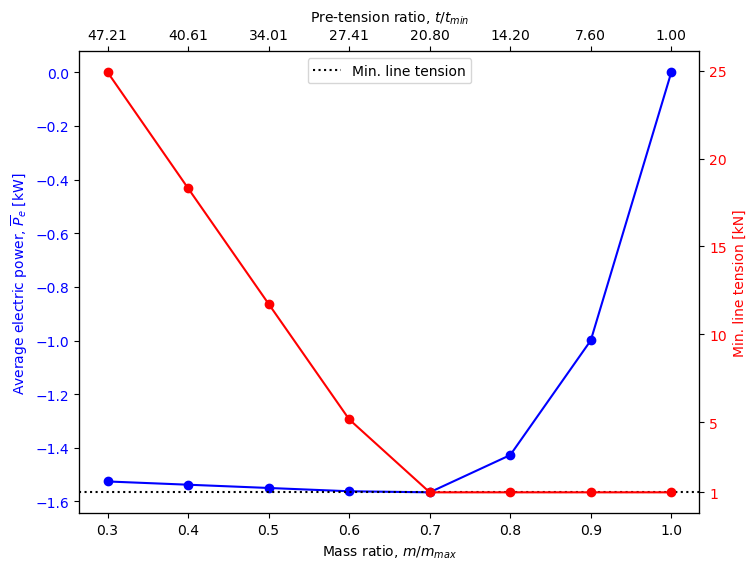

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(res[2], res[3]/1e3, 'bo-')
ax.set_xlabel("Mass ratio, $m/m_{max}$")
ax.set_ylabel("Average electric power, $\overline{P}_e$ [kW]", color="b")
ax.tick_params(axis='y', labelcolor="b")

# second tick
new_tick_locations = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
def tick_function(x):
    mass = np.array(x) * max_mass 
    pretension_ratio = -1*g*(displaced_mass - mass) / min_line_tension
    return [f"{tr:.2f}" for tr in np.squeeze(pretension_ratio)]
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("Pre-tension ratio, $t/t_{min}$")

ax3 = ax.twinx()
ax3.axhline(-1*min_line_tension/1e3, linestyle='dotted', color='black',
            label='Min. line tension')
ax3.plot(res[2], np.abs(max_torque)/1e3, 'ro-')
ax3.set_ylabel("Min. line tension [kN]", color="r")
ax3.tick_params(axis='y', labelcolor="r")
ax3.set_yticks([1, 5, 10, 15, 20, 25])
ax3.legend(loc=9)